In [1]:
from miniGPT import GPT
from gym.wrappers import TimeLimit, RecordEpisodeStatistics, NormalizeObservation, NormalizeReward, TransformObservation
import gym
import torch
import random
from collections import deque
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# func to quantize state
def binary(num, length=4):
    return [int(i) for i in list(format(num, '#0{}b'.format(length + 2)))[2:]]

# gym
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)
max_ep_length = 2**5 # maximum number that can exists in timesteps
max_episodes = 300
env = TimeLimit(env, max_episode_steps=max_ep_length)
env = TransformObservation(env, f=lambda x: binary(x, length=4))
#env = NormalizeObservation(env)
#env = NormalizeReward(env)
env = RecordEpisodeStatistics(env, deque_size=max_ep_length)
state_dim = 4 #env.observation_space.n
action_dim = env.action_space.n
print(f"state_dim: {state_dim}, action_dim: {action_dim}")


# model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_config = GPT.get_default_config()
model_config.model_type = 'gpt-mini'
model_config.vocab_size = 4 # which integers can exist 16 is max for observation
model_config.block_size = max_ep_length * (model_config.vocab_size+action_dim) # sequence max size
model = GPT(model_config).to(device)
print(model_config)

optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
loss_fn = torch.nn.SmoothL1Loss()

state_dim: 4, action_dim: 4
number of parameters: 2.72M
model_type: gpt-mini
n_layer: 6
n_head: 6
n_embd: 192
vocab_size: 4
block_size: 256
embd_pdrop: 0.1
resid_pdrop: 0.1
attn_pdrop: 0.1



In [3]:
# [s_1, a1_1, a2_1, a3_1, a4_1, s_2, a1_2, a2_2, a3_2, a4_2, ..., s_T, a1_T, a2_T, a3_T, a4_T]
max_memory = model_config.block_size
memory = deque(maxlen=max_memory) # each step saves 5 elements
allGamesMemory = []
print(f"max_memory: {max_memory/4}")

losses = []
episode_rewards = []

max_memory: 64.0


In [4]:
def train(allGamesMemory, model):
    model.train()
    epochs = 10
    for i in range(epochs):
        smalestGame = min(allGamesMemory, key=len)
        k = random.randint(2*8, len(smalestGame))
        k_start = random.randint(0, len(smalestGame)-k)

        batch = np.array([game[k_start:k_start+k] for game in allGamesMemory])
        batchUpToTminus1 = torch.tensor(batch[:,:-8], dtype=torch.int).to(device)
        batchTActionPreds = torch.tensor(batch[:, -4:], dtype=torch.int).to(device)

        #print(f"batchUpToTminus1: {batchUpToTminus1.shape}")
        #print(f"batchT: {batchTActionPreds.shape}")

        logits, loss = model(batchUpToTminus1) # dont take last sequence

        action_preds = logits[:, 0]

        #print(f"action_preds: {action_preds.shape}")
        #print(f"batchTActionPreds: {batchTActionPreds.shape}")

        loss = loss_fn(action_preds, batchTActionPreds)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().item())

        # remove smalest games
        



In [5]:
observation, info = env.reset()
games = 1
epsilon = 1
action = [0 for _ in range(action_dim)]
while games < max_episodes:
    memory.extend(observation)
    memory.extend(action)

    actionIndex = 0
    action = [0 for _ in range(action_dim)]
    # agent act
    mem = torch.tensor(memory, dtype=torch.int).unsqueeze(0).to(device)
    model.eval()
    logits, loss = model(mem)

    logits = logits.squeeze(0) # remove batch dim
    action_preds = logits[0]
    if random.random() < epsilon:
        actionIndex = env.action_space.sample()
    else:
        actionIndex = torch.argmax(action_preds).item()


    observation, reward, terminated, truncated, info = env.step(actionIndex)

    # if truncated then -1 reward
    if truncated:
        action[actionIndex] = 0
    elif reward > 0:
        action[actionIndex] = reward
    elif terminated:
        action[actionIndex] = -1
        

    # learn from what we predicted to what is truth
    if games % 10 == 0:
        train(allGamesMemory, model)



    epsilon = max(epsilon * 0.999, 0.01)

    # if done
    if terminated or truncated:
        #if (games % 100) == 0:
        print(f"games: {games},  epsilon: {epsilon}, episode: {info['episode']}")
        print(f"preds: {action_preds.detach().cpu().numpy()}, best_action: {torch.argmax(action_preds).item()}")
        episode_rewards.append(info["episode"]["r"])
        allGamesMemory.append(list(memory))
        memory.clear()
        
        games += 1

        action = [0 for _ in range(action_dim)]
        t = 1

        observation, info = env.reset()

/home/pedron18/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


games: 1,  epsilon: 0.9870777147137147, episode: {'r': 0.0, 'l': 13, 't': 2.385608}
preds: [ 0.16787426 -0.40090892 -0.11771061 -0.37472376], best_action: 0
games: 2,  epsilon: 0.9588496310845509, episode: {'r': 0.0, 'l': 29, 't': 2.532094}
preds: [ 0.16787422 -0.40090895 -0.11771045 -0.37472382], best_action: 0
games: 3,  epsilon: 0.9483548639781193, episode: {'r': 0.0, 'l': 11, 't': 2.580803}
preds: [ 0.1678742  -0.40090895 -0.11771061 -0.37472394], best_action: 0
games: 4,  epsilon: 0.9379749638258457, episode: {'r': 0.0, 'l': 11, 't': 2.631553}
preds: [ 0.1678742  -0.40090895 -0.11771061 -0.37472394], best_action: 0
games: 5,  epsilon: 0.9304973749532338, episode: {'r': 0.0, 'l': 8, 't': 2.66811}
preds: [ 0.16787426 -0.400909   -0.11771063 -0.3747241 ], best_action: 0
games: 6,  epsilon: 0.9093297114626595, episode: {'r': 0.0, 'l': 23, 't': 2.769585}
preds: [ 0.16787426 -0.400909   -0.11771063 -0.3747241 ], best_action: 0
games: 7,  epsilon: 0.8984775710829266, episode: {'r': 0.0, 

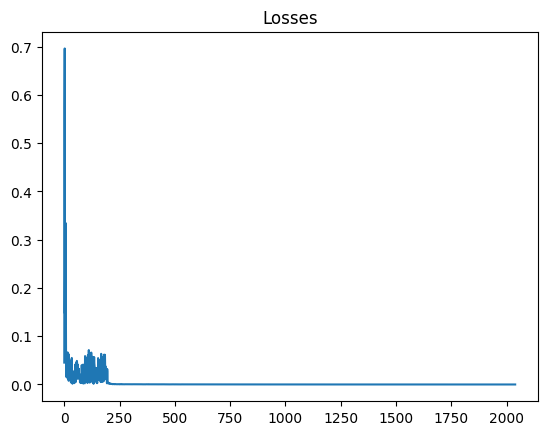

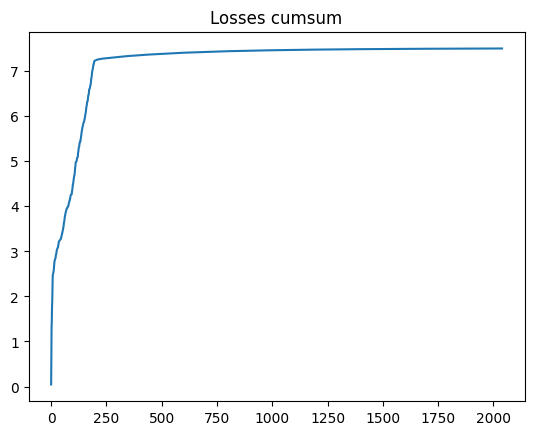

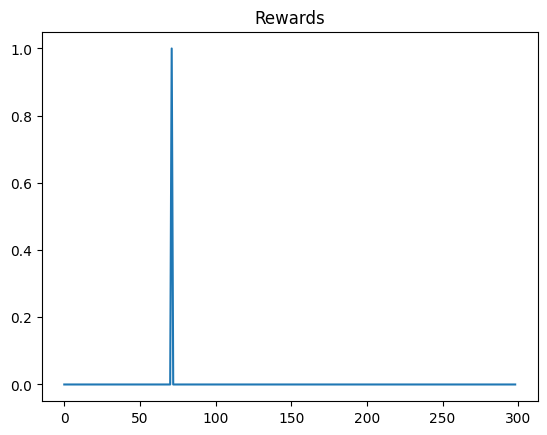

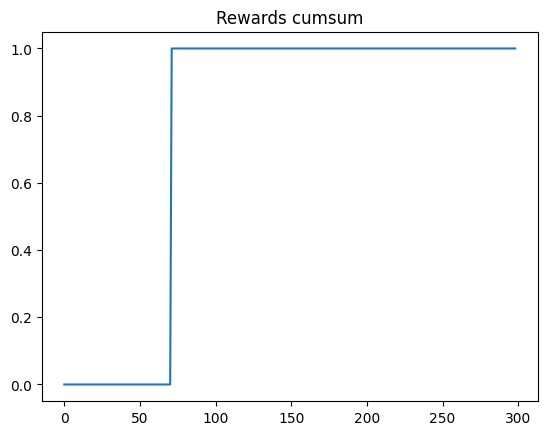

In [6]:
memory.clear()

# plot losses
plt.plot(losses)
plt.title('Losses')
plt.show()

plt.plot(np.cumsum(losses))
plt.title('Losses cumsum')
plt.show()

plt.plot(episode_rewards)
plt.title('Rewards')
plt.show()

plt.plot(np.cumsum(episode_rewards))
plt.title('Rewards cumsum')
plt.show()
